In [1]:
import itertools
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import animation
import numpy as np
import pandas as pd
from numpy import genfromtxt

from IPython.display import HTML
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
#az.style.use('arviz-darkgrid')

In [6]:
rs = genfromtxt("../toy_rs_argp.txt", filling_values=-float('inf'), delimiter=" ").T
seq = genfromtxt("../toy_seq_argp.txt")
cp_probs = genfromtxt("../toy_change_points_argp.txt")

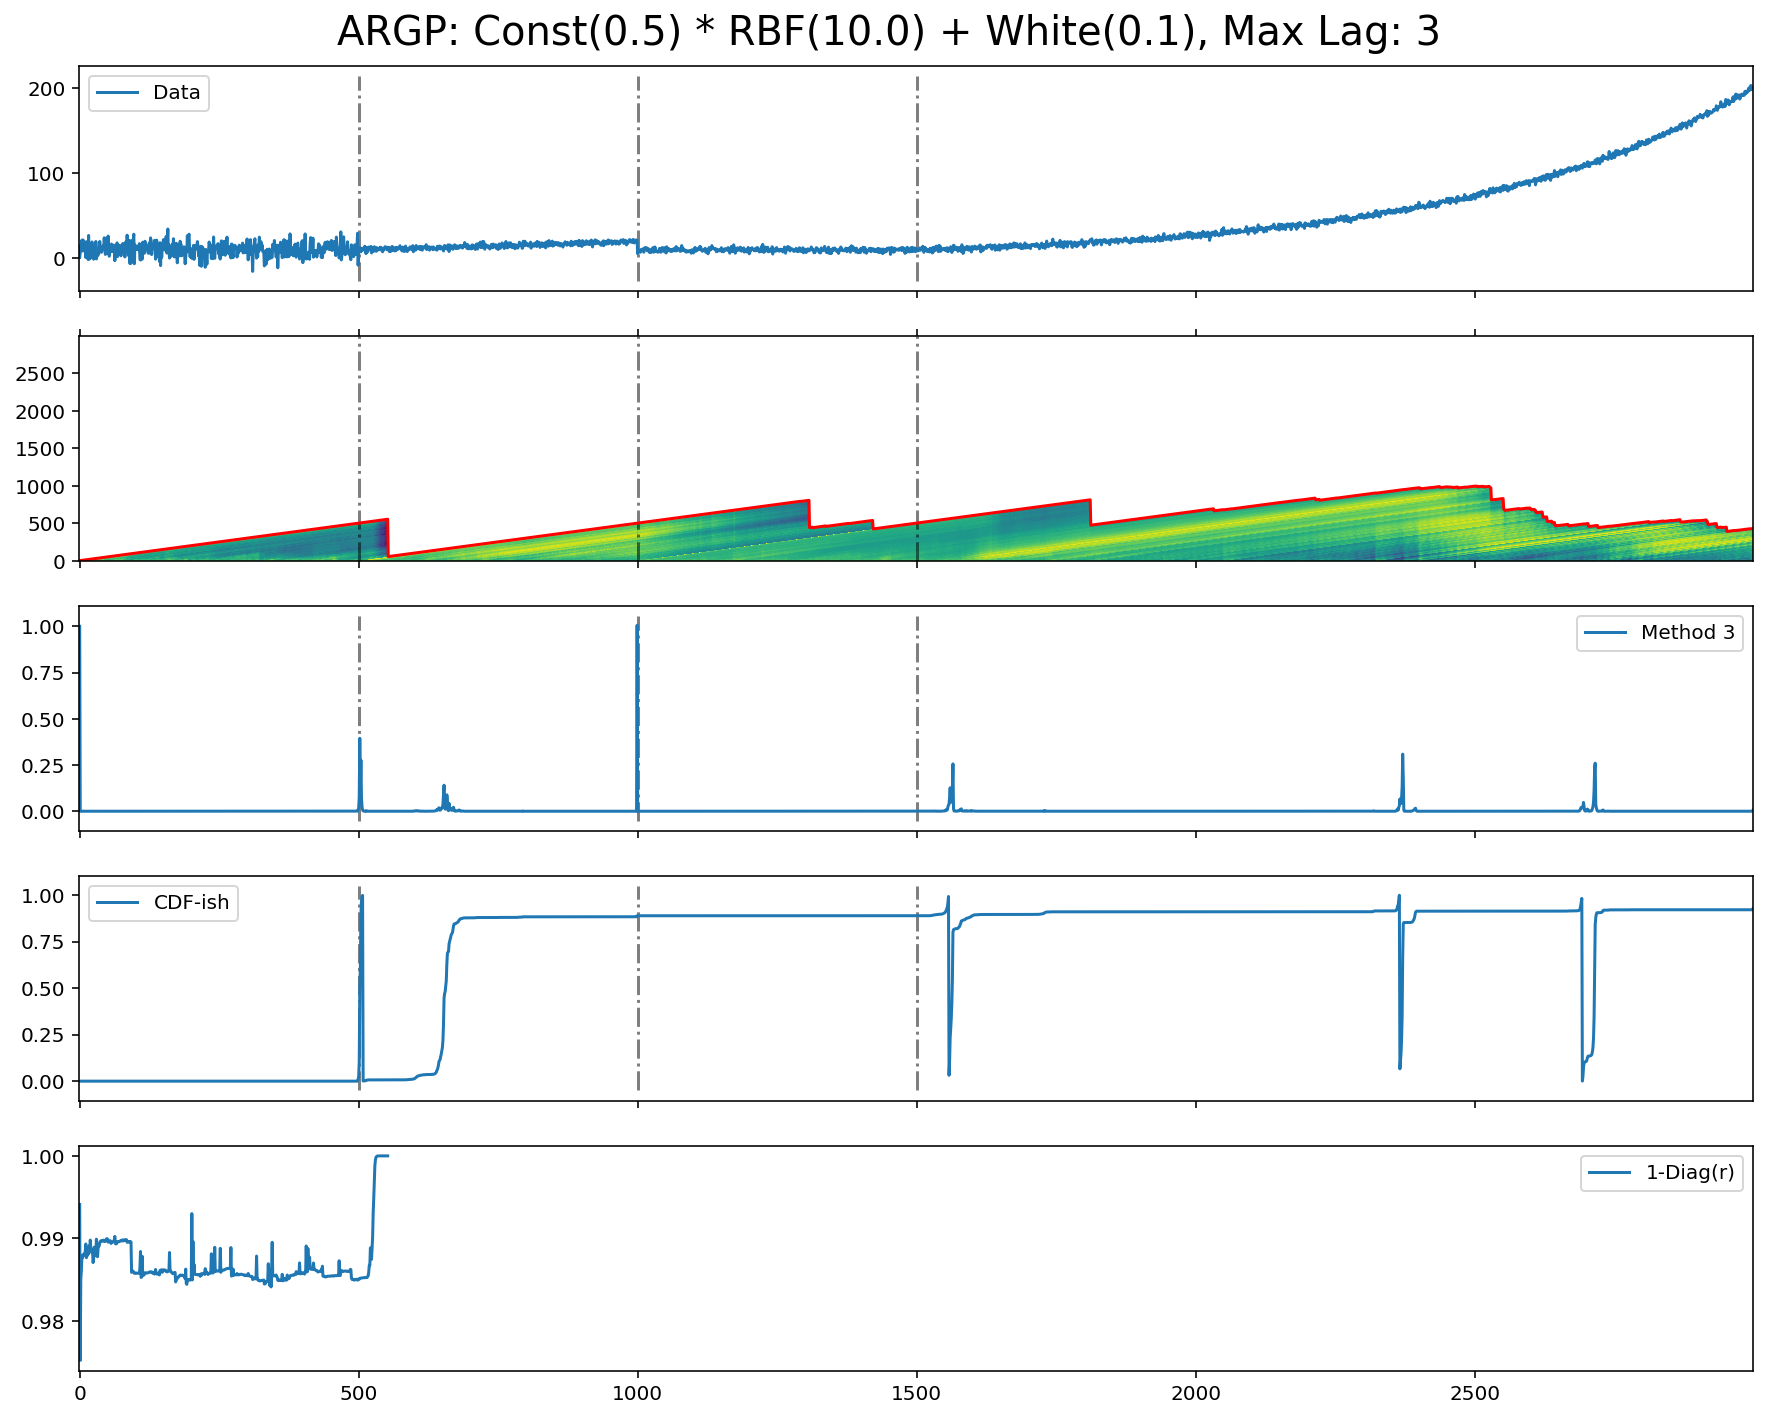

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
xs = np.arange(0, len(rs))

axs[0].plot(seq, label="Data")
axs[0].legend()

axs[1].matshow(np.log(rs), origin="lower", aspect="auto")
max_prob_lifetime = np.array(np.argmax(np.log(rs), axis=0))
axs[1].plot(max_prob_lifetime, c="r")


axs[2].plot(xs, cp_probs, label="Method 3")
axs[2].legend()

axs[3].plot(xs, np.mod(np.cumsum(cp_probs), 1.0), label="CDF-ish")
axs[3].legend()

axs[4].plot(1.0 - np.diag(rs), label="1-Diag(r)")
axs[4].legend()

for i in range(0, 4):
    axs[i].vlines([500, 1000, 1500], ymin=axs[i].get_ylim()[0], ymax=axs[i].get_ylim()[1], linestyle='-.', alpha=0.5)
fig.suptitle("ARGP: Const(0.5) * RBF(10.0) + White(0.1), Max Lag: 3", y=0.91, fontsize=20)

plt.show()
fig.savefig("ARGP-Toy-Exponential.png")

In [8]:
segment_bounds = []
acc = 0
for i, pcp in enumerate(cp_probs):
    acc += pcp
    if acc >= 1.0:
        segment_bounds.append(i)
        acc -= 1.0

In [9]:
segment_bounds

[0, 508, 999, 1558, 2366, 2693]

In [63]:
def map_cp_dist(r):
    s = len(r) - 1
    cps = []
    while s > 0:
        pr = r[s, :s+1]
        s = s - np.argmax(pr)
        cps.append(s)
    return list(reversed(cps))

In [64]:
map_cp_dist(rs.T)

[0, 502, 653, 794, 999, 1565]

In [15]:
def mc_cp_dist(r, n=1000):
    """Walk backwards through the sequence, via mc"""
    bins = np.zeros(len(r), dtype=np.float64)
    for _i in range(n):
        s = len(r) - 1
        while s > 0:
            pr = r[s, :s+1]
            s = s - np.random.choice(range(s+1), p=pr)
            bins[s] += 1
    return bins / n

/Users/bdannowitz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


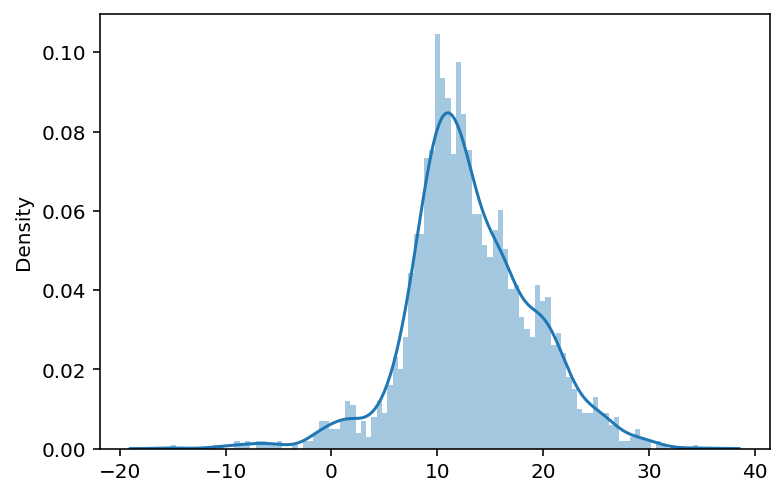

In [16]:
sns.distplot(seq, bins=100)

/Users/bdannowitz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


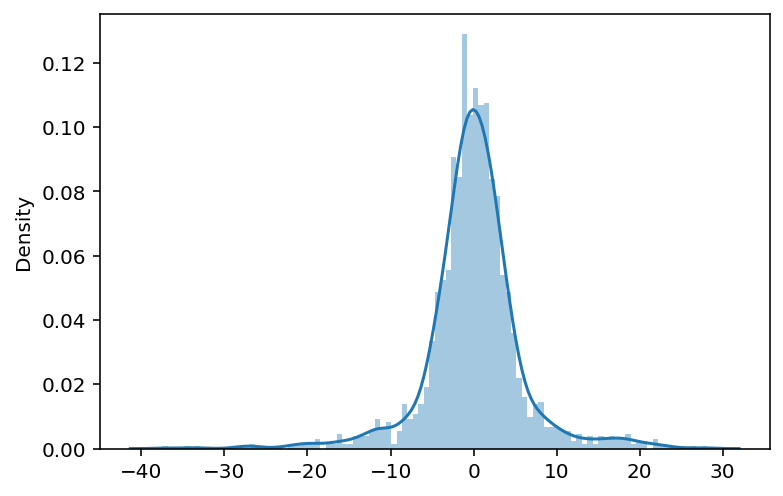

In [17]:
sns.distplot(np.diff(seq), bins=100)

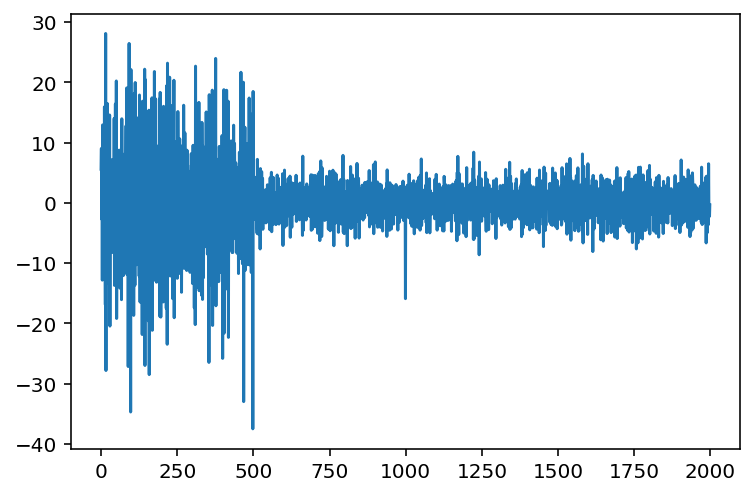

In [18]:
plt.plot(np.diff(seq))

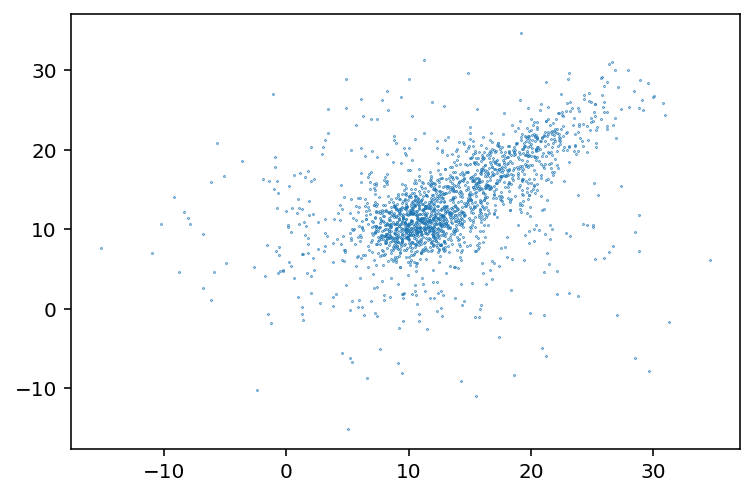

In [19]:
plt.scatter(seq[:-1], seq[1:], s=0.1)